# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Model training & UI Exploration</span>

<span style="font-width:bold; font-size: 1.4rem;">In this last notebook, we will train a model on the dataset we created in the previous tutorial. We will train our model using standard Python and 🤖🤖🤖🤖🤖🤖, although it could just as well be trained with other machine learning frameworks such as Scikit-learn, PySpark, TensorFlow, and PyTorch. We will also show some of the exploration that can be done in Hopsworks, notably the search functions and the lineage. </span>

## **🗒️ This notebook is divided in 3 main sections:** 
1. **Loading the training data.**
2. **Train models.**
3. **Model's Predictions Visualization.**

![tutorial-flow](images/03_model.png)

To begin with lets connect to Hopsworks Feature Store

In [1]:
import hsfs

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

First, we'll need to fetch the training dataset that we created in the previous notebook.

To retrieve training dataset from Feature Store we retrieve **Feature View** using `FeatureStore.get_feature_view` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_training_dataset` method.

In [2]:
feature_view = fs.get_feature_view(
    name = "train_data",
    version = 1
)

In [3]:
# Load data. 

# td_version, df = feature_view.get_training_dataset_splits(
#     splits = {'train': 80, 'validation': 20},
#     version = 1
# )
# X_train = df["train"]
# X_val = df['validation']

# df

In [4]:
td_version, df = feature_view.get_training_dataset()

df.head()

2022-06-06 20:15:17,795 INFO: USE `credit_scores_featurestore`
2022-06-06 20:15:18,465 INFO: SELECT `fg1`.`sk_id_curr` `sk_id_curr`, `fg1`.`target` `target`, `fg1`.`name_contract_type` `name_contract_type`, `fg1`.`code_gender` `code_gender`, `fg1`.`flag_own_car` `flag_own_car`, `fg1`.`flag_own_realty` `flag_own_realty`, `fg1`.`cnt_children` `cnt_children`, `fg1`.`amt_income_total` `amt_income_total`, `fg1`.`amt_credit` `amt_credit`, `fg1`.`amt_annuity` `amt_annuity`, `fg1`.`amt_goods_price` `amt_goods_price`, `fg1`.`name_type_suite` `name_type_suite`, `fg1`.`name_income_type` `name_income_type`, `fg1`.`name_education_type` `name_education_type`, `fg1`.`name_family_status` `name_family_status`, `fg1`.`name_housing_type` `name_housing_type`, `fg1`.`region_population_relative` `region_population_relative`, `fg1`.`days_birth` `days_birth`, `fg1`.`days_employed` `days_employed`, `fg1`.`days_registration` `days_registration`, `fg1`.`days_id_publish` `days_id_publish`, `fg1`.`flag_mobil` `fla

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,previous_loan_counts
0,140282,0,0,0,0,0,0,112500.0,1046142.0,30717.0,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,2
1,196458,0,1,0,0,1,0,76500.0,225000.0,11250.0,...,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0,3
2,194978,0,0,1,1,1,0,112500.0,1585224.0,42637.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8
3,118340,0,0,0,0,1,1,135000.0,1147500.0,31684.5,...,0,0,0,0.0,0.0,0.0,0.0,2.0,5.0,3
4,205876,0,0,0,0,0,0,225000.0,396000.0,26505.0,...,0,0,0,0.0,0.0,0.0,1.0,2.0,2.0,3


Let's check the distribution of our target label.

In [5]:
df.target.value_counts(normalize=True)

0    0.922725
1    0.077275
Name: target, dtype: float64

Notice that the distribution is extremely skewed, which is natural considering that fraudulent transactions make up a tiny part of all transactions. Thus we should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, we'll use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (fraudulent) samples.

---

# <span style="color:#ff5f27;"> 🤖 Modeling</span>

#### <span style="color:#ff5f27;">📝 Importing Libraries</span>

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score

## <span style="color:#ff5f27;"> 🪓 Data Splitting</span>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['sk_id_curr','target'],axis = 1),
    df.target,
    test_size = 0.2,
    random_state = 42
)

---

## <span style="color:#ff5f27;"> 🧑🏻‍🔬 RandomForestClassifier</span>

In [8]:
pos_class_weight = 0.9

In [9]:
model = RandomForestClassifier(
    n_estimators = 25,
    max_features = 'sqrt',
    class_weight = {0: 1.0 - pos_class_weight, 1: pos_class_weight},
    n_jobs = -1,
    random_state = 42
)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.09999999999999998, 1: 0.9},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [10]:
preds = model.predict(X_test)

accuracy_score(y_test, preds)

0.919929718875502

---

## <span style="color:#ff5f27;"> 🧑🏻‍🔬 XGBoost</span>

In [11]:
xgb_reg = xgb.XGBClassifier(
    n_estimators = 15,
    random_state = 42
)

xgb_reg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [12]:
preds = xgb_reg.predict(X_test)

accuracy_score(y_test, preds)

0.9184236947791165

---

## <span style="color:#ff5f27;"> 🔬 🧬 Model Predictions Visualization</span>

In [13]:
import plotly.express as px
import seaborn as sns
%matplotlib inline 

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [14]:
data = X_test.copy()
data['labels'] = preds
data['real'] = y_test

columns = df.apply(pd.Series.var).sort_values(ascending = False).index[:3]

/srv/hops/anaconda/envs/theenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



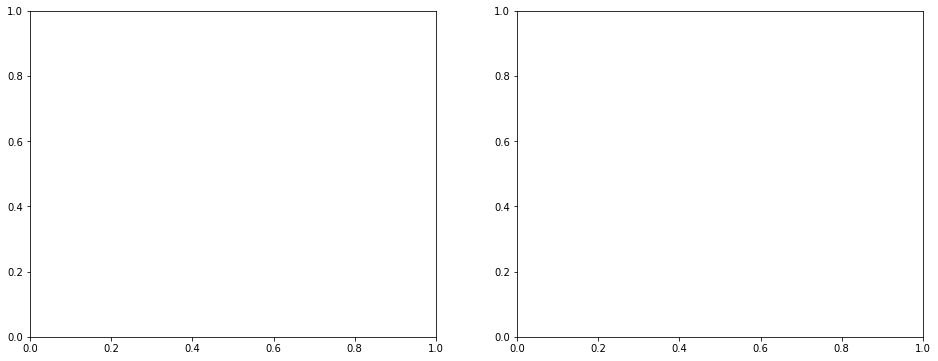

In [15]:
fig,ax = plt.subplots(1,2,figsize = (16,6))

ax[0] = px.scatter_3d(data, x=columns[0], y=columns[1], z=columns[2],
                    color='labels')

ax[1] = px.scatter_3d(data, x=columns[0], y=columns[1], z=columns[2],
                    color='real')

fig.show('notebook')

---